<a href="https://colab.research.google.com/github/zhukuixi/d2l/blob/main/dropout_fromScratchfromAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip uninstall matplotlib
!pip install matplotlib==3.0.0
!pip install matplotlib_inline

import torch
from torch import nn
import numpy as np
from d2l import torch as d2l
from torch.utils import data


ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/uninstall.py", line 86, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_install.py", line 658, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_uninstall.py", line 380, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_uninstall.py", line 423, in _allowed_to_proceed
    return ask('Proceed (y/n)? ', ('y', 'n')) == 'y'
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/misc.py", line 203, in ask
    response = input(message)
KeyboardInterrupt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
y


# from Scratch
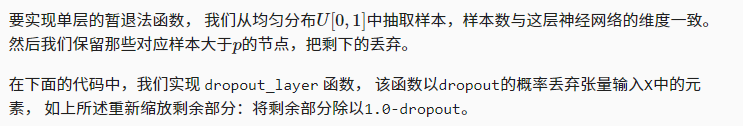

In [4]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [25]:
dropout1, dropout2 = 0.2, 0.5
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

# 注意下面这个class是标准的pytorch模型写法。至少要自己写__init__()方法和forward()方法
# 首先这个类继承了nn.Module,因此在其__init__方法中必须写super(自己类名, self).__init__()来完成nn.Module的初始化
# 其次在__init__()方法中定义网络的各个部分，再在forward()中将他们连接起来
# 如果实例化之后，比如net = Net(...)，net(X)其实是调用了继承的__call__()函数，里面实际上调用了forward()方法！
# https://blog.csdn.net/qq_33590958/article/details/103544470 这里讲的不错！

# 注意这里is_training函数，非常重要，说明了只有在is_training=True的时候才会加入dropout层
# 那么模型如何转换train/evaluation的状态呢！通过 net.train() net.eval()方法即可！ 这些方法都是nn.Module中的！
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

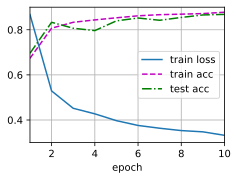

In [26]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# API实现
- 对于深度学习框架的高级API，我们只需在每个全连接层之后添加一个Dropout层， 将暂退概率作为唯一的参数传递给它的构造函数。 在训练时，Dropout层将根据指定的暂退概率随机丢弃上一层的输出（相当于下一层的输入）。 在测试时，Dropout层仅传递数据。

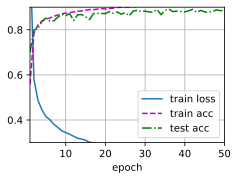

In [74]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, 50, trainer)

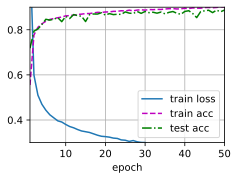

In [32]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, 50, trainer)

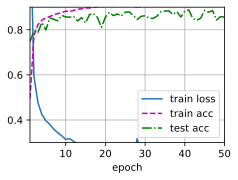

In [33]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        
        nn.Linear(256, 256),
        nn.ReLU(),
     
       
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, 50, trainer)

In [43]:
# 方法一
# 打印某一层的参数名
for name in model.state_dict():
    print(name)
# 直接索引某一层的name来输出该层的参数
print(model.state_dict()['1.weight'])

1.weight
1.bias
3.weight
3.bias
5.weight
5.bias
tensor([[ 0.0025,  0.0053,  0.0151,  ...,  0.0627,  0.0615,  0.0130],
        [-0.0067, -0.0133, -0.0058,  ...,  0.0010, -0.0074, -0.0217],
        [ 0.0027, -0.0248,  0.0052,  ...,  0.0102,  0.0088,  0.0285],
        ...,
        [ 0.0111, -0.0042, -0.0102,  ...,  0.0162,  0.0089, -0.0062],
        [ 0.0003, -0.0129, -0.0076,  ...,  0.0031, -0.0010, -0.0083],
        [-0.0079, -0.0011,  0.0055,  ..., -0.0033, -0.0266, -0.0040]])


In [70]:
net1 = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net1.apply(init_weights);
trainer1 = torch.optim.SGD(net1.parameters(), lr=lr)

In [71]:
net2 = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
       
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
       
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net2.apply(init_weights);
trainer2 = torch.optim.SGD(net2.parameters(), lr=lr)

In [72]:


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

print(net1)
print(net2)

net1[2].register_forward_hook(get_activation('relu1'))
net1[4].register_forward_hook(get_activation('relu2'))

net2[2].register_forward_hook(get_activation('noDrop_relu1'))
net2[4].register_forward_hook(get_activation('noDrop_relu2'))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=True)
)


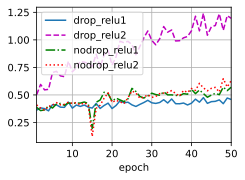

In [73]:
def train_temp(net1,net2, train_iter, test_iter, loss, num_epochs, updater1,updater2): 
    """训练模型（定义见第3章）"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], 
                        legend=['drop_relu1', 'drop_relu2', 'nodrop_relu1','nodrop_relu2'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net1, train_iter, loss, updater1)
        d2l.train_epoch_ch3(net2, train_iter, loss, updater2)
        print((activation['relu1'].std(),activation['relu2'].std(),activation['noDrop_relu1'].std(),activation['noDrop_relu2'].std()))
        animator.add(epoch + 1, (activation['relu1'].std(),activation['relu2'].std(),activation['noDrop_relu1'].std(),activation['noDrop_relu2'].std()))
   

train_temp(net1,net2, train_iter, test_iter, loss, 50, trainer1,trainer2)

In [73]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);
trainer = torch.optim.SGD(net.parameters(), lr=lr)


trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias} 
        {"params":net[3].weight,'weight_decay': wd},
        {"params":net[3].bias}
        {"params":net[6].weight,'weight_decay': wd},
        {"params":net[6].bias}
        ], lr=lr)

d2l.train_ch3(net, train_iter, test_iter, loss, 50, trainer)
